# 以OpenCV實作人臉偵測、特徵捕捉與變裝
2021/03/08 蘇彥庭

這個小專題是我在Tibame AI/Big Data資料分析師養成班的OpenCV課程後的自主練習。

主要是以筆電攝像頭拍攝自己的人臉，程式會偵測人臉位置，並在人臉上加入一些貼圖做變裝。

這個功能目前在坊間的修圖軟體皆可以看到，我自己是利用[OpenCV](https://opencv.org/)搭配[Dlib函數庫](http://dlib.net/)來實作。

成果範例：

![](./images/demo.gif)

In [1]:
# 使用套件
import cv2          # pip install opencv-python
import dlib         # pip install dlib
from matplotlib import pyplot as plt

在dlib函數庫中，主要用到兩個模型，分別為：
* 人臉偵測模型：

此處使用[dlib.get_frontal_face_detector()](http://dlib.net/python/index.html#dlib.get_frontal_face_detector)函數的內建預設模型。

* 人臉特徵捕捉模型

此處使用dlib加載預訓練模型：shape_predictor_68_face_landmarks.dat，詳細資訊及模型下載位置可參考官網[Github說明](https://github.com/davisking/dlib/blob/master/python_examples/face_landmark_detection.py)，及此篇文章[Facial landmarks with dlib, OpenCV, and Python](https://www.pyimagesearch.com/2017/04/03/facial-landmarks-dlib-opencv-python/)。

此模型會針對人臉標記出68個特徵點，如下圖所示：
![](./images/face_point.png)

我們針對每次攝像頭讀進來的畫面，先透過人臉偵測模型找出畫面內每張臉的位置。再來透過人臉特徵捕捉模型，標記出每張臉的68個特徵位置。之後即可依據68個特徵位置的相對關係，放入我們想要的素材貼圖，完成人臉的變裝。

In [2]:
# 讀取人臉偵測模型
detector = dlib.get_frontal_face_detector()

# 讀取人臉特徵捕捉模型
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

首先我們先以靜態的照片來進行人臉偵測與特徵捕捉，這是本次實作的靜態照片：

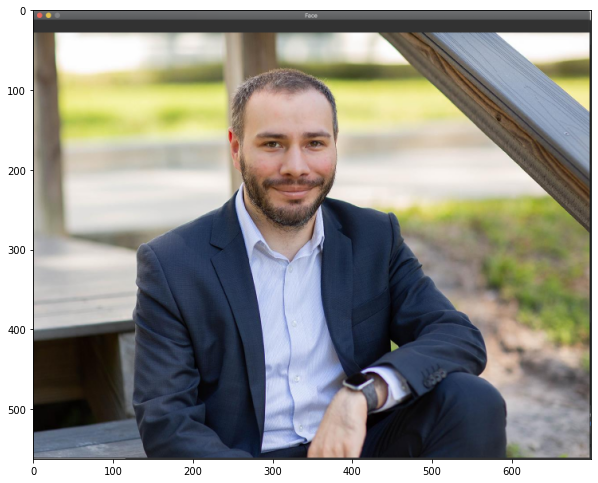

In [3]:
# 讀取照片
img = cv2.imread("./images/face.png")

# 呈現照片
plt.figure(figsize = (10, 10))                    # 此為放大呈現圖片
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # 由於cv2是以BGR格式儲存照片 以matplotlib繪圖時要轉為RGB

針對這張靜態照片，我們可以先透過detector找出人臉的位置：

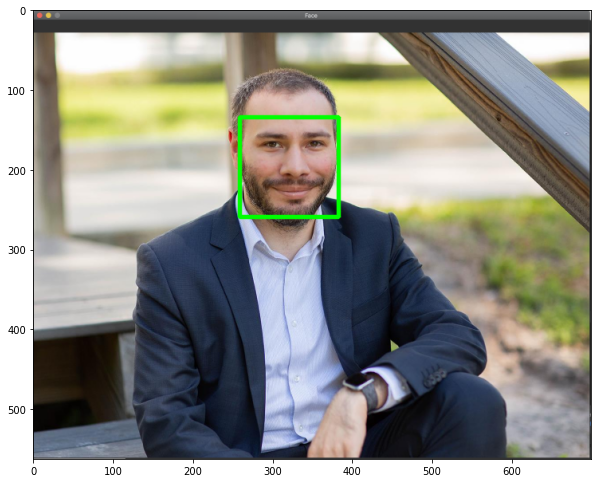

In [4]:
# 複製原始照片
detectorImg = img.copy()

# 將照片轉換為灰階照片以做臉部辨識
gray = cv2.cvtColor(src=detectorImg, code=cv2.COLOR_BGR2GRAY)

# 依灰階照片內容進行人臉偵測模型
faces = detector(gray)

# 迴圈每張偵測到的人臉
for face in faces:
    
    # 人臉偵測到的範圍
    x1 = face.left()
    y1 = face.top()
    x2 = face.right()
    y2 = face.bottom()
    
    # 繪製矩形標記偵測到的人臉範圍
    cv2.rectangle(detectorImg, (x1, y1), (x2, y2), (0, 255, 0), 4, cv2.LINE_AA)

# 呈現標記特徵點後的照片
plt.figure(figsize = (10, 10))
plt.imshow(cv2.cvtColor(detectorImg, cv2.COLOR_BGR2RGB))

在detector辨識出人臉後，即可透過predictor標註出人臉的特徵點：

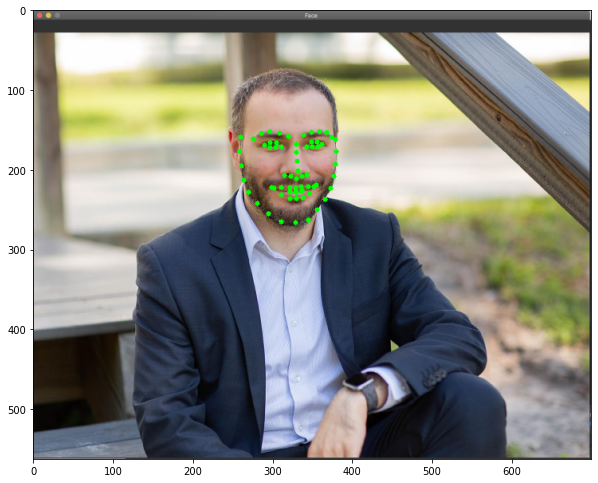

In [5]:
# 複製原始照片
landmarkImg = img.copy()

# 將照片轉換為灰階照片以做臉部辨識
gray = cv2.cvtColor(src=landmarkImg, code=cv2.COLOR_BGR2GRAY)

# 依灰階照片內容進行人臉偵測模型
faces = detector(gray)

# 迴圈每張偵測到的人臉
for face in faces:
    
    # 臉部特徵標記位置
    landmarks = predictor(image=gray, box=face)
    
    # 在照片上標記各個特徵點
    for n in range(0, 68):
        
        # 特徵點的x和y
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        
        # 繪製圓圈點標記特徵點
        cv2.circle(img=landmarkImg, center=(x, y), radius=3, color=(0, 255, 0), thickness=-1)

# 呈現標記特徵點後的照片
plt.figure(figsize = (10, 10))
plt.imshow(cv2.cvtColor(landmarkImg, cv2.COLOR_BGR2RGB))

這是要貼上人臉的素材貼圖-裝逼墨鏡：

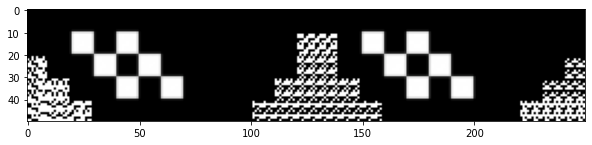

In [6]:
# 讀取素材貼圖
materialImg = cv2.imread("./images/sunglasses.png")
plt.figure(figsize = (10, 10))
plt.imshow(cv2.cvtColor(materialImg, cv2.COLOR_BGR2RGB))

接下來我們將素材貼圖貼到人臉上，由於是墨鏡，所以要把貼圖放到眼睛的位置上會比較合理。

我們可以利用人臉的68個特徵點來抓出想要放置的範圍，此處先畫出貼圖預計放置的區域：

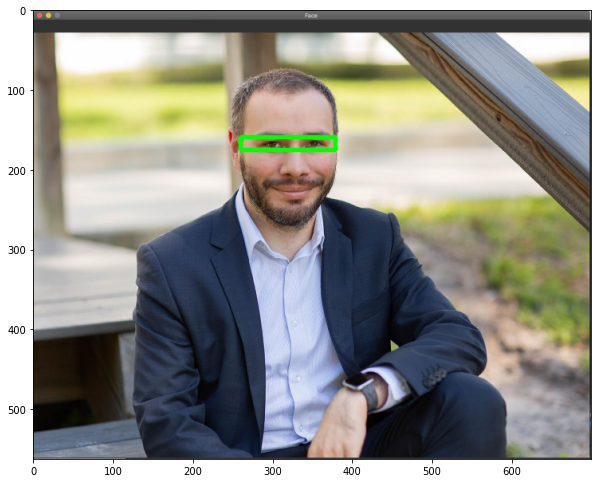

In [7]:
# 複製原始照片
rangeImg = img.copy()

# 將照片轉換為灰階照片以做臉部辨識
gray = cv2.cvtColor(src=rangeImg, code=cv2.COLOR_BGR2GRAY)

# 依灰階照片內容進行人臉偵測模型
faces = detector(gray)

# 迴圈每張偵測到的人臉
for face in faces:
    
    # 臉部特徵標記位置
    landmarks = predictor(image=gray, box=face)
    
    # 貼圖放置區的起始位置(特徵第0點)
    x1 = landmarks.part(0).x
    y1 = landmarks.part(0).y
    
    # 貼圖放置區的寬度和高度
    width = landmarks.part(16).x - landmarks.part(0).x   # 特徵第16點和第0點的寬度距離
    height = landmarks.part(1).y - landmarks.part(17).y  # 特徵第1點和第17點的高度距離
    
    # 貼圖放置區的結束位置(即貼圖放置區右下角)
    x2 = x1 + width
    y2 = y1 + height
    
    # 貼圖放置區的範圍
    cv2.rectangle(rangeImg, (x1, y1), (x2, y2), (0, 255, 0), 4, cv2.LINE_AA)
    
# 呈現貼圖放置區
plt.figure(figsize = (10, 10))
plt.imshow(cv2.cvtColor(rangeImg, cv2.COLOR_BGR2RGB))

貼圖放置區即為墨鏡貼圖要放置的地方，以下是放置墨鏡貼圖的程式碼：

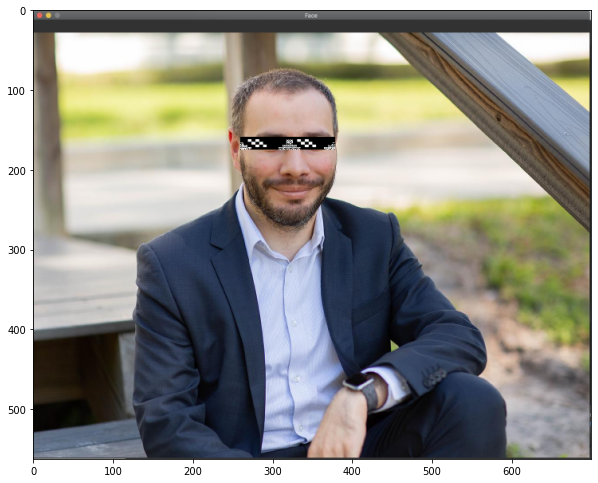

In [8]:
# 複製原始照片
rangeImg = img.copy()

# 將照片轉換為灰階圖片以做臉部辨識
gray = cv2.cvtColor(src=rangeImg, code=cv2.COLOR_BGR2GRAY)

# 依灰階照片內容進行人臉偵測模型
faces = detector(gray)

# 迴圈每張偵測到的人臉
for face in faces:
    
    # 臉部特徵標記位置
    landmarks = predictor(image=gray, box=face)
    
    # 素材貼圖貼入的起始位置
    x1 = landmarks.part(0).x
    y1 = landmarks.part(0).y
    
    # 計算素材貼圖的寬度和高度
    width = landmarks.part(16).x - landmarks.part(0).x
    height = landmarks.part(1).y - landmarks.part(17).y
    
    # 調整素材貼圖
    materialImgResize = cv2.resize(materialImg, (width, height))
    
    # 貼入素材貼圖
    rangeImg[y1:(y1+height), x1:(x1+width)] = materialImgResize
    
# 呈現標記特徵點後的照片
plt.figure(figsize = (10, 10))
plt.imshow(cv2.cvtColor(rangeImg, cv2.COLOR_BGR2RGB))

貼完之後，如果仔細看照片可以發現墨鏡以外的雜訊像素區域也會被貼進來，變成很不自然，所以還要做一些處理。

由於我們的素材圖片是png格式，png格式除了RGB三個channel外，還有多一個是透明度(alpha)channel。

In [9]:
# 讀取素材照片
# 此處要加入'cv2.IMREAD_UNCHANGED'才能讀入alpha channel
materialImg = cv2.imread("./images/sunglasses.png", cv2.IMREAD_UNCHANGED)

# 印出 B channel矩陣
print('B channel:')
print(materialImg[:, :, 0])
print('='*30)

# 印出 R channel矩陣
print('R channel:')
print(materialImg[:, :, 1])
print('='*30)

# 印出 G channel矩陣
print('G channel:')
print(materialImg[:, :, 2])
print('='*30)

# 印出 alpha channel矩陣
print('alpha channel:')
print(materialImg[:, :, 3])

B channel:
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0 255 ... 255 255 255]
 [  0   0 255 ... 255   0 255]
 [255 255   0 ... 255 255   0]]
R channel:
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0 255 ... 255 255 255]
 [  0   0 255 ... 255   0 255]
 [255 255   0 ... 255 255   0]]
G channel:
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   0 255 ... 255 255 255]
 [  0   0 255 ... 255   0 255]
 [255 255   0 ... 255 255   0]]
alpha channel:
[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [  2   2   0 ...   0   0   0]
 [  2   2   0 ...   0   2   0]
 [  0   0   2 ...   0   0   2]]


alpha channel的值愈大代表愈不透明，愈趨近於0代表愈透明。

所以我們可以利用alpha channel的資訊，建立出一個遮罩(mask)，讓素材貼圖的雜訊位置channel全部變為0。

接著將人臉照片在貼圖放置區內的照片擷取出來，把剛做的遮罩reverse(即0變1、1變0)，非素材貼圖雜訊對應的像素位置全部歸0。

最後即可把兩張照片加在一起，素材貼圖透明的像素位置會以人臉照片對應的像素位置取代，這樣貼入照片時就不會有違和感。

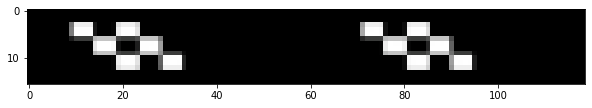

In [10]:
# 讀取素材貼圖
# 此處要加入'cv2.IMREAD_UNCHANGED'才能讀入alpha channel
sunglassesImg = cv2.imread("./images/sunglasses.png", cv2.IMREAD_UNCHANGED)

# 將素材圖片alpha channel小於一定的值給0
sunglassesImg[:, :, 3][sunglassesImg[:, :, 3] <= 125] = 0 

# 調整素材貼圖
materialImgResize = cv2.resize(sunglassesImg, (width, height))

# 建立mask
materialImgMask = materialImgResize[:, :, 3] > 125
materialImgMask = materialImgMask.astype('uint8')

# 取RGB channel
materialImgResize = materialImgResize[:, :, 0:3]

# mask素材貼圖
materialImgResize = cv2.bitwise_and(materialImgResize, materialImgResize, mask=materialImgMask)

# 呈現mask後的素材貼圖
plt.figure(figsize = (10, 10))
plt.imshow(cv2.cvtColor(materialImgResize, cv2.COLOR_BGR2RGB))

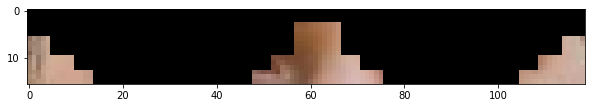

In [11]:
# 處理素材對應的圖片位置
# 選取照片貼圖放置區的範圍
imgTarget = img[y1:(y1+height), x1:(x1+width)] 

# 建立mask
imgMask = 1-materialImgMask

# 對照片進行mask
imgTarget = cv2.bitwise_and(imgTarget, imgTarget, mask=imgMask)

# 呈現mask後的照片
plt.figure(figsize = (10, 10))
plt.imshow(cv2.cvtColor(imgTarget, cv2.COLOR_BGR2RGB))

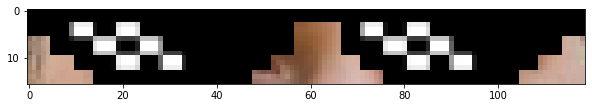

In [12]:
# 結合mask後的素材圖片和mask後的照片
combineImg = cv2.add(materialImgResize, imgTarget)

# 輸出結合後的照片
plt.figure(figsize = (10, 10))
plt.imshow(cv2.cvtColor(combineImg, cv2.COLOR_BGR2RGB))

我們將上面的所有程式碼彙整起來：

In [13]:
# 使用套件
import cv2          # pip install opencv-python
import dlib         # pip install dlib
from matplotlib import pyplot as plt

# 讀取人臉偵測模型
detector = dlib.get_frontal_face_detector()

# 讀取人臉特徵捕捉模型
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# 讀取照片
img = cv2.imread("./images/face.png")

# 讀取素材照片
materialImg = cv2.imread("./images/sunglasses.png", cv2.IMREAD_UNCHANGED)
materialImg[:, :, 3][materialImg[:, :, 3] <= 125] = 0 

# 將照片轉換為灰階照片以做臉部辨識
gray = cv2.cvtColor(src=img, code=cv2.COLOR_BGR2GRAY)

# 依灰階照片內容進行人臉偵測模型
faces = detector(gray)

# 迴圈每張偵測到的人臉
for face in faces:
    
    # 臉部特徵標記位置
    landmarks = predictor(image=gray, box=face)
    
    # 素材貼圖貼入的起始位置
    x1 = landmarks.part(0).x
    y1 = landmarks.part(0).y
    
    # 計算素材貼圖的寬度和高度
    width = landmarks.part(16).x - landmarks.part(0).x
    height = landmarks.part(1).y - landmarks.part(17).y
    
    # 調整素材貼圖寬度和高度
    materialImgResize = cv2.resize(sunglassesImg, (width, height))
    
    # 建立mask
    materialImgMask = materialImgResize[:, :, 3] > 125
    materialImgMask = materialImgMask.astype('uint8')

    # 取RGB channel
    materialImgResize = materialImgResize[:, :, 0:3]
    
    # mask素材貼圖
    materialImgResize = cv2.bitwise_and(materialImgResize, materialImgResize, mask=materialImgMask)
    
    # 選取照片貼圖放置區的範圍
    imgTarget = img[y1:(y1+height), x1:(x1+width)] 

    # 建立mask
    imgMask = 1-materialImgMask

    # 對照片進行mask
    imgTarget = cv2.bitwise_and(imgTarget, imgTarget, mask=imgMask)
    
    # 結合mask後的素材圖片和mask後的照片
    combineImg = cv2.add(materialImgResize, imgTarget)

    # 貼入素材圖片
    img[y1:(y1+height), x1:(x1+width)] = combineImg

處理完後輸出照片，貼圖看起來就很不錯了！

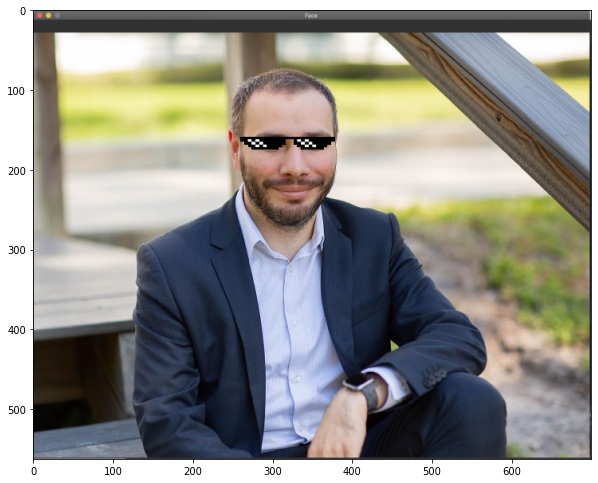

In [14]:
# 呈現標記特徵點後的照片
plt.figure(figsize = (10, 10))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

接下來將程式碼導入筆電攝像結合，並將上述程式碼改為物件導向。

程式碼可參考我的[Github](https://github.com/SuYenTing/opencv_face_stickers/blob/main/main.py)，執行程式碼後，筆電會開啟鏡頭偵測前方是否有人臉，若有人臉會貼上素材圖片。